In [0]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# importing torch & its classes
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

# importing matplotlib for plotting graphs
import matplotlib.style as ms
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# importing fastai lib
from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats, LossMetrics
import fastai
from fastai import train as tr



In [2]:
# check if cuda available for GPU use
torch.cuda.is_available()

True

In [3]:
# reading train & test data from repective files

train = pd.read_pickle('all_jets_train_4D_100_percent.pkl')
test = pd.read_pickle('all_jets_test_4D_100_percent.pkl')
n_features = len(train.loc[0]) #number of features (4 here)
train.head(10)

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871
61832,6236.774414,30013.537109,-2.962712,0.091814
26867,17774.943359,205705.046875,2.472530,-1.299140
46232,4181.291992,20511.900391,-1.937396,-1.893408
44194,4537.854492,29095.220703,2.703056,-1.746550
59782,6769.761719,26334.353516,1.344461,-2.599911


In [0]:
# getting train & test data as Tensor Dataset

train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building an AE (try to build same output as the input)
test_y = test_x

# train & validation datasets
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float32), torch.tensor(train_y.values, dtype=torch.float32))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float32), torch.tensor(test_y.values, dtype=torch.float32))


In [0]:
# function to load data as DataBunch from Tensor Dataset
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [0]:
# Randomly assign train and valid data
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=256)

In [0]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [0]:
# Autoencoder Net for 4D to 3D to 4D
class AE_3D_200(nn.Module):
    def __init__(self, n_features=4):
        '''Model Declaration'''
        super(AE_3D_200, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 100)
        self.en3 = nn.Linear(100, 50)
        self.en4 = nn.Linear(50, 3)
        self.de1 = nn.Linear(3, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200, n_features)

        # using tanh activation function
        self.tanh = nn.Tanh()

    def encode(self, x):
        ''' to get encoded data '''
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        ''' to get decoded data '''
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        ''' forward pass '''
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        ''' network description '''
        return 'in-200-100-50-3-50-100-200-out'


class RMSELoss(torch.nn.Module):
    ''' Return RMSE loss for each iteration of forward and backward prop'''
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

# Loss Function
loss_func = RMSELoss()


In [0]:
bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6

# Our model declaration
model = AE_3D_200()
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [10]:
# to find learning rate for our model
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


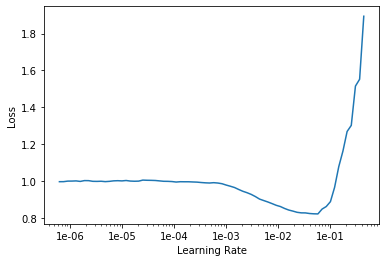

In [11]:
# plot the learning rate
learn.recorder.plot()

In [12]:
# we choose learning rate as 1e-6
lr = 1e-6

# fit our model
learn.fit(1000, lr=lr, wd=wd)



epoch,train_loss,valid_loss,time
0,0.984513,0.999851,00:03
1,0.980984,0.990029,00:03
2,0.971323,0.978575,00:03
3,0.966755,0.965158,00:04
4,0.945087,0.949779,00:04
5,0.926211,0.932562,00:04
6,0.904378,0.913663,00:04
7,0.888620,0.893357,00:04
8,0.868007,0.871879,00:04
9,0.843835,0.849514,00:04


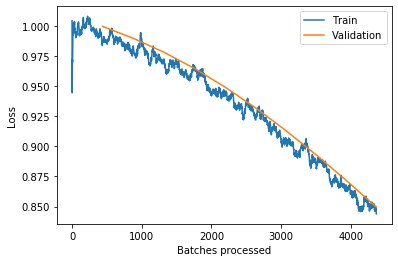

In [13]:
# to plot the train and validate loss
learn.recorder.plot_losses()

In [0]:
# Saving our model
learn.save('AE_3D_200_trained')


In [15]:
# validating
learn.validate()

[0.84951395]

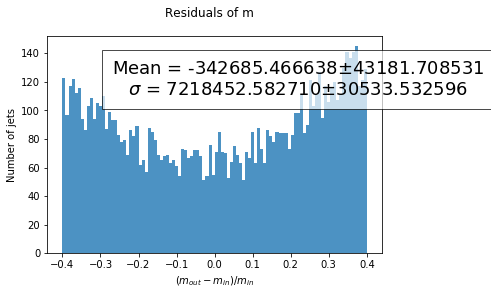

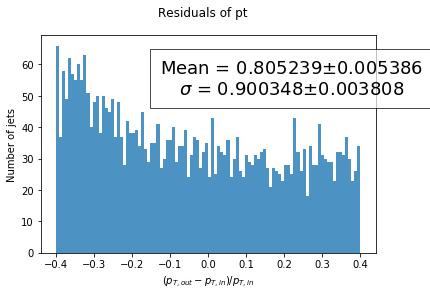

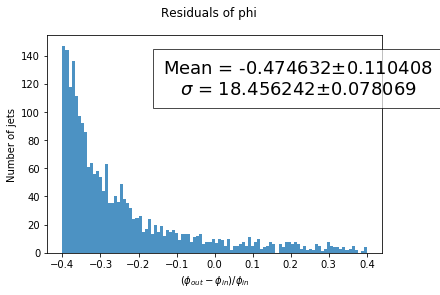

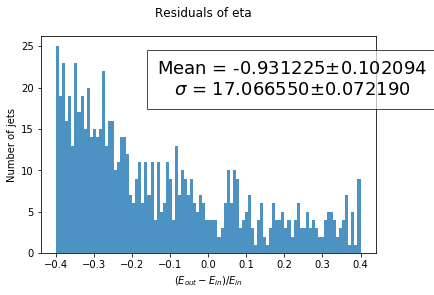

In [16]:
# Plotting Graphs for loss percentage

unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

learn.model.to('cpu')
idxs = (0, 100000)  # Choose events to compare

# getting the output data
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype = torch.float32)
pred = learn.model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)

# Saving uncompressed output data
np.save('reduced_features', pred)

# getting the input data
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50

from scipy import stats

residual_strings = [r'$(m_{out} - m_{in}) / m_{in}$',
                        r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']

# formula used for plot 
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
range = (-.4, .4)
for kk in np.arange(4):
    plt.figure()
    
    # Plotting the histogram graph
    n_hist_pred, bin_edges, _ = plt.hist(residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=range)
   
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk]) 
    plt.ylabel('Number of jets')
    std = np.std(residuals[:, kk])
    std_err = np.nanstd(residuals[:, kk], axis=None, ddof=0) / np.sqrt(2 * len(residuals[:, kk]))
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

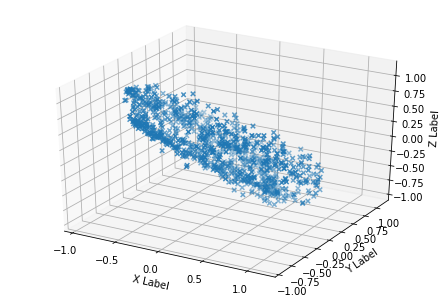

In [17]:
# Plotting the first 1000 encoded OR 3D data

learn.model.to('cpu')
idxs = (0, 1000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype = torch.float32)
threed = learn.model.encode(data).detach().numpy()

fig = plt.figure()
ax = Axes3D(fig)

x = threed[:,0]
y = threed[:,1]
z = threed[:,2]

ax.scatter(x, y, z, marker='x')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()